# Imports and Data

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import scipy.interpolate as interpol
import statsmodels.api as sm
import pymannkendall as mk
import time
import copy
import math
import pickle


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

with open('unfiltered.pkl', 'rb') as handle:
    unfiltered = pickle.load(handle)
handle.close()

with open('../itdata/mtl_unfiltered.pickle', 'rb') as handle:
    tmpunf = pickle.load(handle)
    handle.close()
    
unfiltered.update(tmpunf)

with open('../itdata/mtl_dffa15.pickle', 'rb') as handle:
    itdffa15 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_dffa30.pickle', 'rb') as handle:
    itdffa30 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_livesd.pickle', 'rb') as handle:
    itlives = pickle.load(handle)
    handle.close()
    
# unfiltered['mit'] = pc.allcalls('../usadata/CallLog.csv', ('type', 'outgoing', 'outgoing+', 'missed'), 'participantID.A', 'number.hash', 
#                                 ['local_time'], "%Y-%m-%d %H:%M:%S", header=True, min_activity=1)
unfiltered['mit'] = pd.read_csv("data/USc.txt", sep="\t", parse_dates=[3, 4]).rename({'a': 'aclock', 't': 'uclock'}, axis='columns')
unfiltered['uk12'] = pd.DataFrame()
for c in ['uk1', 'uk2']:
    df = unfiltered[c].copy(deep=True)
    df['ego'] = df['ego'].map(lambda i: f'{dict({"uk1": "a", "uk2": "b"})[c]}{i}')
    unfiltered['uk12'] = unfiltered['uk12'].append(df)

L = {'uk': 300, 'uk1': 300, 'uk2': 270, 'it': 365, 'itb': 365, 'mit': 220}
calls = {}
for c in ['uk', 'uk1', 'uk2', 'it', 'mit']:
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max()
    keep = lf.loc[lf['aclock'] <= L[c]]
    df = df[df['ea'].isin(keep.index)]
    calls[c] = pc.apply_filters(df, 60)
calls['uk12'] = pd.DataFrame()
for c in ['uk1', 'uk2']:
    df = calls[c].copy(deep=True)
    df['ego'] = df['ego'].map(lambda i: f'{dict({"uk1": "a", "uk2": "b"})[c]}{i}')
    calls['uk12'] = calls['uk12'].append(df)
    
    
globalt0 = dt.datetime.now()

/tmp/ipykernel_4972/1628031994.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  unfiltered['uk12'] = unfiltered['uk12'].append(df)
/tmp/ipykernel_4972/1628031994.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  calls['uk12'] = calls['uk12'].append(df)


In [2]:
for c in ['uk2', 'it', 'mit']:
    df = calls[c].copy(deep=True)
    df['pair'] = list(zip(df['ego'], df['alter']))
    print(c, len(df['pair'].unique()))

uk2 920
it 4052
mit 2653


In [3]:
for c in ['uk', 'uk2', 'it', 'mit']:
    print(c, min(unfiltered[c]['time']), max(unfiltered[c]['time']), max(unfiltered[c]['uclock']) - min(unfiltered[c]['uclock']))

uk 2007-03-05 13:17:00 2008-08-31 20:13:00 545
uk2 2007-09-01 15:05:00 2008-08-31 20:13:00 365
it 2013-02-01 08:03:16 2014-12-31 23:46:21 698
mit 2010-02-27 15:37:07 2011-07-16 19:55:04 504


# Fig 1 with resampling
The resampling is all about making all cohorts comparable.

In [3]:
for c in ['it', 'mit']:
    # No Filter
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    print(c, len(df['ea'].unique()))
    # L
    lf = df.groupby('ea')[['aclock']].max()
    keep = lf.loc[lf['aclock'] <= L[c]]
    df = df[df['ea'].isin(keep.index)]
    print(c, len(df['ea'].unique()))
    # ncalls = df.groupby('ea')[['time']].count()
    # keep = ncalls.loc[ncalls['time'] >= 3]
    # df = df[df['ea'].isin(keep.index)]
    # calls[{'it': 'itL', 'mit': 'mitL'}[c]] = df
    # print(c, len(df['ea'].unique()))
    # Delta t to the left (by ego)
    t0i = df.groupby('ego')['uclock'].min()
    print(t0i[24])
    t0x = df.groupby('ea')[['uclock']].min()
    t0x['dif'] = t0x.index.map(lambda i: t0x.at[i, 'uclock'] - t0i[i[0]])
    keep = t0x.loc[t0x['dif'] > 50]
    df = df[df['ea'].isin(keep.index)]
    print(len(df['ea'].unique()))
    # Delta t to the right
    df = pc.apply_filters(df, 60)
    df['ea'] = list(zip(df['ego'], df['alter']))
    print(len(df['ea'].unique()))
    calls[{'it': 'itb', 'mit': 'mitb'}[c]] = df

it 23674
it 21064
4
17501
2736
mit 10860
mit 10263
225
7474
1542


In [4]:
tmp = calls['itb'].copy(deep=True)
tmp['ea'] = list(zip(tmp['ego'], tmp['alter']))
t0i = tmp.groupby('ego')['uclock'].min()
t0x = tmp.groupby('ea')[['uclock']].min()
t0x['t0'] = t0x.index.map(lambda i: t0x.at[i, 'uclock'] - t0i[i[0]])
tmp2 = t0x.loc[t0x['t0'] > 50]
df = tmp[tmp['ea'].isin(tmp2.index)]

In [6]:
for c in ['uk2', 'itb', 'it', 'mit']:
    df = calls[c].copy(deep=True)
    df['pair'] = list(zip(df['ego'], df['alter']))
    print(c, len(df['pair'].unique()))

uk2 920
itb 2736
it 4052
mit 2653


In [7]:
limits = {}
for c in ['uk2', 'itb', 'it', 'mit']:
    limits[c] = []
    limits[c].append((0, 50))
    limits[c].append((L[c] // 2 - 25, L[c]//2 + 25))
    limits[c].append((L[c] - 50, L[c]))
limits

{'uk2': [(0, 50), (110, 160), (220, 270)],
 'itb': [(0, 50), (157, 207), (315, 365)],
 'it': [(0, 50), (157, 207), (315, 365)],
 'mit': [(0, 50), (85, 135), (170, 220)]}

In [8]:
t0 = dt.datetime.now()
fig1 = {}
for c in ['uk2', 'itb', 'it', 'mit']:
    fig1[c] = {}
    for i in range(3):
        fig1[c][i] = pc.get_fal(calls[c], limits[c][i][0], limits[c][i][1], 15, countalters=True)
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:02.420460


In [9]:
dashed = {}
for c in ['uk2', 'itb', 'it', 'mit']:
    dashed[c] = {}
    print(f'======================={c}=====================')
    for lamb in fig1[c].keys():
        if lamb >= 0:
            points = pc.get_b_slopes(fig1[c][lamb]['f'])
            print(pc.get_b_mk(fig1[c][lamb]['f']))
            dashed[c][lamb] = points
            print(f'\draw[dashed, {["charmander", "squirtle", "ekans"][lamb]}, ultra thick] (axis cs: {points[0][0]}, {points[1][0]}) -- (axis cs: {points[0][1]}, {points[1][1]});')

=======================uk2=====================
[[1, 2], [0.663175464631242, 0.663175464631242], 999]
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.663175464631242) -- (axis cs: 2, 0.663175464631242);
[[1, 9], [1.87373430853823, 1.87373430853823], 999]
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 1.87373430853823) -- (axis cs: 9, 1.87373430853823);
[[1, 16], [2.4968990752451297, 2.4968990752451297], 999]
\draw[dashed, ekans, ultra thick] (axis cs: 3, 2.448535988086695) -- (axis cs: 13, 2.448535988086695);
=======================itb=====================
[[1, 2], [0.5495548728469455, 0.5495548728469455], 999]
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.5495548728469455) -- (axis cs: 2, 0.5495548728469455);
[[1, 12], [0.8390481094780258, 0.8390481094780258], 999]
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 0.8390481094780258) -- (axis cs: 12, 0.8390481094780258);
[[1, 23], [1.8565024008234312, 1.8565024008234312], 999]
\draw[dashed, ekans, ultra thick] (axis c

# Confidence Intervals for $f(a, \ell)$

## Using a $T$ distribution

In [10]:
from scipy.stats import t as tst
t0 = dt.datetime.now()
fig1cit = {}
for c in fig1.keys():
    fig1cit[c] = {}
    for l in fig1[c].keys():
        fig1cit[c][l] = pd.DataFrame()
        dict1 = {}
        for idx in fig1[c][l]['f'].index:
            dict1[idx] = []
            for ego in fig1[c][l]['fi'].keys():
                df = fig1[c][l]['fi'][ego].copy()
                if idx in df.index:
                    dict1[idx].append(df.at[idx, 'f'])
                else:
                    continue
        for a in fig1[c][l]['f'].index:
            m = fig1[c][l]['f'].at[a, 'f']
            s = np.std(dict1[a])
            dof = len(dict1[a]) - 1
            conf = 0.95
            t_crit = np.abs(tst.ppf((1-conf)/2,dof))
            fig1cit[c][l].at[a, 'f'] = m
            fig1cit[c][l].at[a, 'below'] = m - (t_crit * (s / np.sqrt(len(dict1[a]))))
            fig1cit[c][l].at[a, 'above'] = m + (t_crit * (s / np.sqrt(len(dict1[a]))))
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.492937


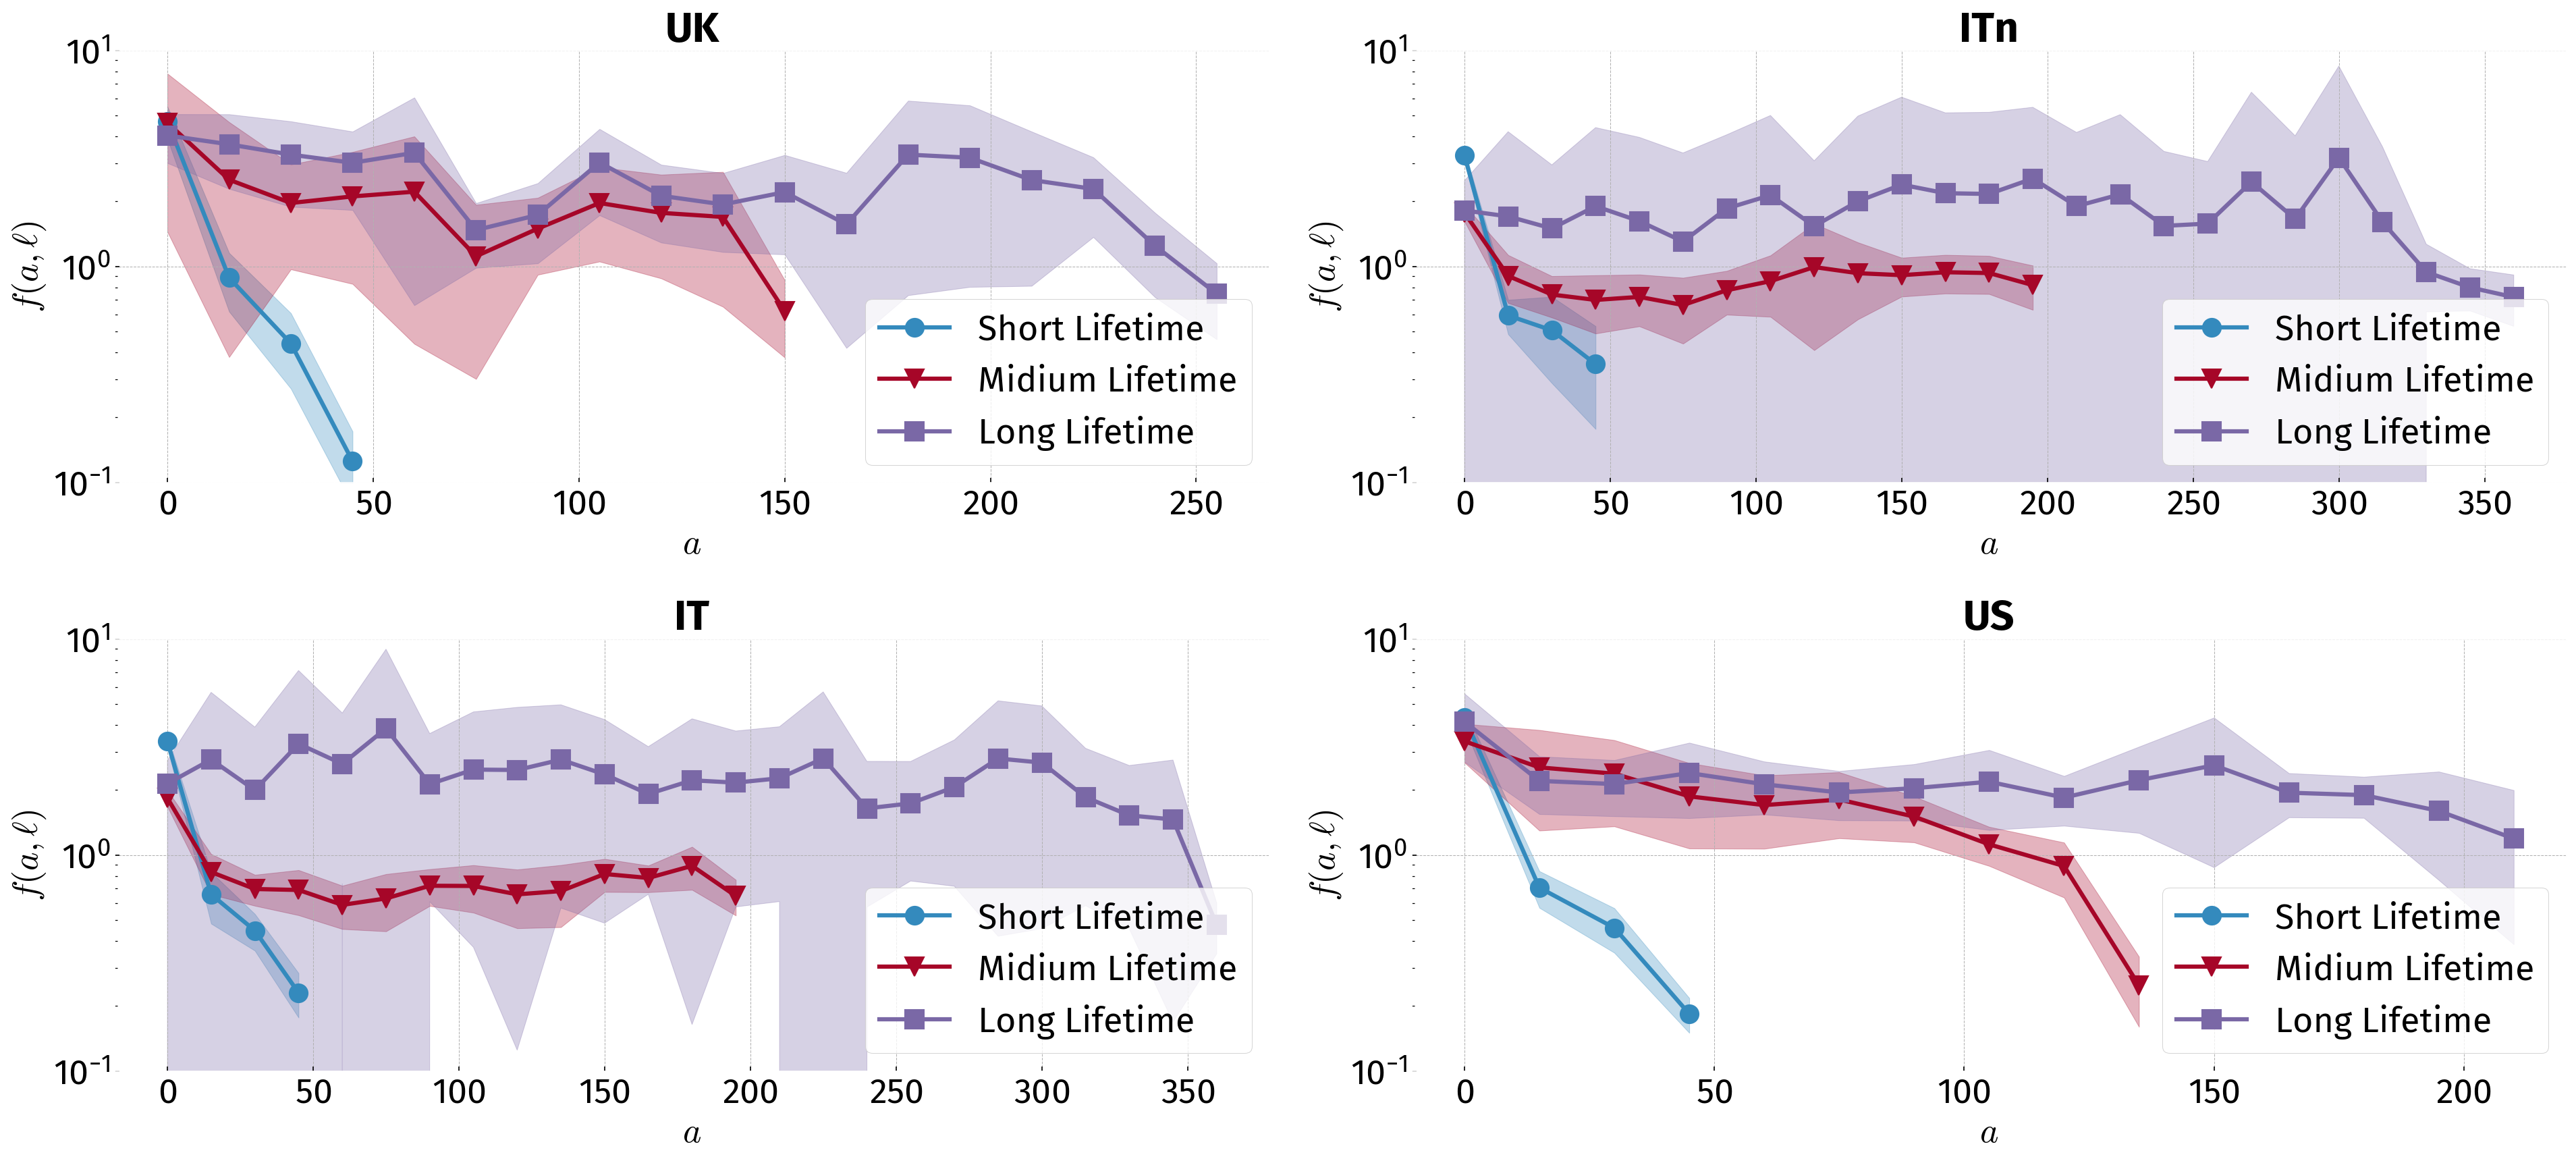

In [56]:
country_labels = {'uk2': 'UK', 'itb': 'ITn', 'it': 'IT', 'mit': 'US'}
nc = 2
nr = 2
plt.figure(figsize=(nc*13, nr*6))
p = 1
for c in fig1cit.keys():
    plt.subplot(nr, nc, p)
    plt.title(f'{country_labels[c]}')
    plt.xlabel('$a$')
    plt.ylabel(r"$f(a, \ell)$")
    plt.semilogy()
    plt.ylim(10**(-1), 10)
    for i in range(3):
        plt.plot(fig1cit[c][i].index * 15, fig1cit[c][i]['f'], marker=markers[i], markersize=13, ls="solid", lw=3, color=colors[i], label=['Short Lifetime', 'Midium Lifetime', 'Long Lifetime'][i])
        # plt.plot(fig1[c][i]['f'].index, fig1[c][i]['f']['f'], marker="X", markersize=8, ls="dashed", lw=3, color="black")
        plt.fill_between(fig1cit[c][i].index * 15, fig1cit[c][i]['below'], fig1cit[c][i]['above'], color=colors[i], alpha=0.3)
    plt.legend()
    plt.tight_layout()
    p += 1

## Using bootstrapping

In [44]:
t0 = dt.datetime.now()
nsample = len(fig1['mit'][2]['fi'].keys())
allsamples = pd.DataFrame()
en = 0
for _ in range(100):
    egosample = np.random.choice(list(fig1['mit'][2]['fi'].keys()), size=nsample, replace=True)
    for ego in egosample:
        df = fig1['mit'][2]['fi'][ego].rename({'f': en}, axis='columns').transpose()
        allsamples = pd.concat([allsamples, df])
        en += 1
        
testing = allsamples.quantile([0.025, 0.975]).transpose().rename({0.025: 'low', 0.975: 'high'}, axis='columns').sort_index()
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:12.827034


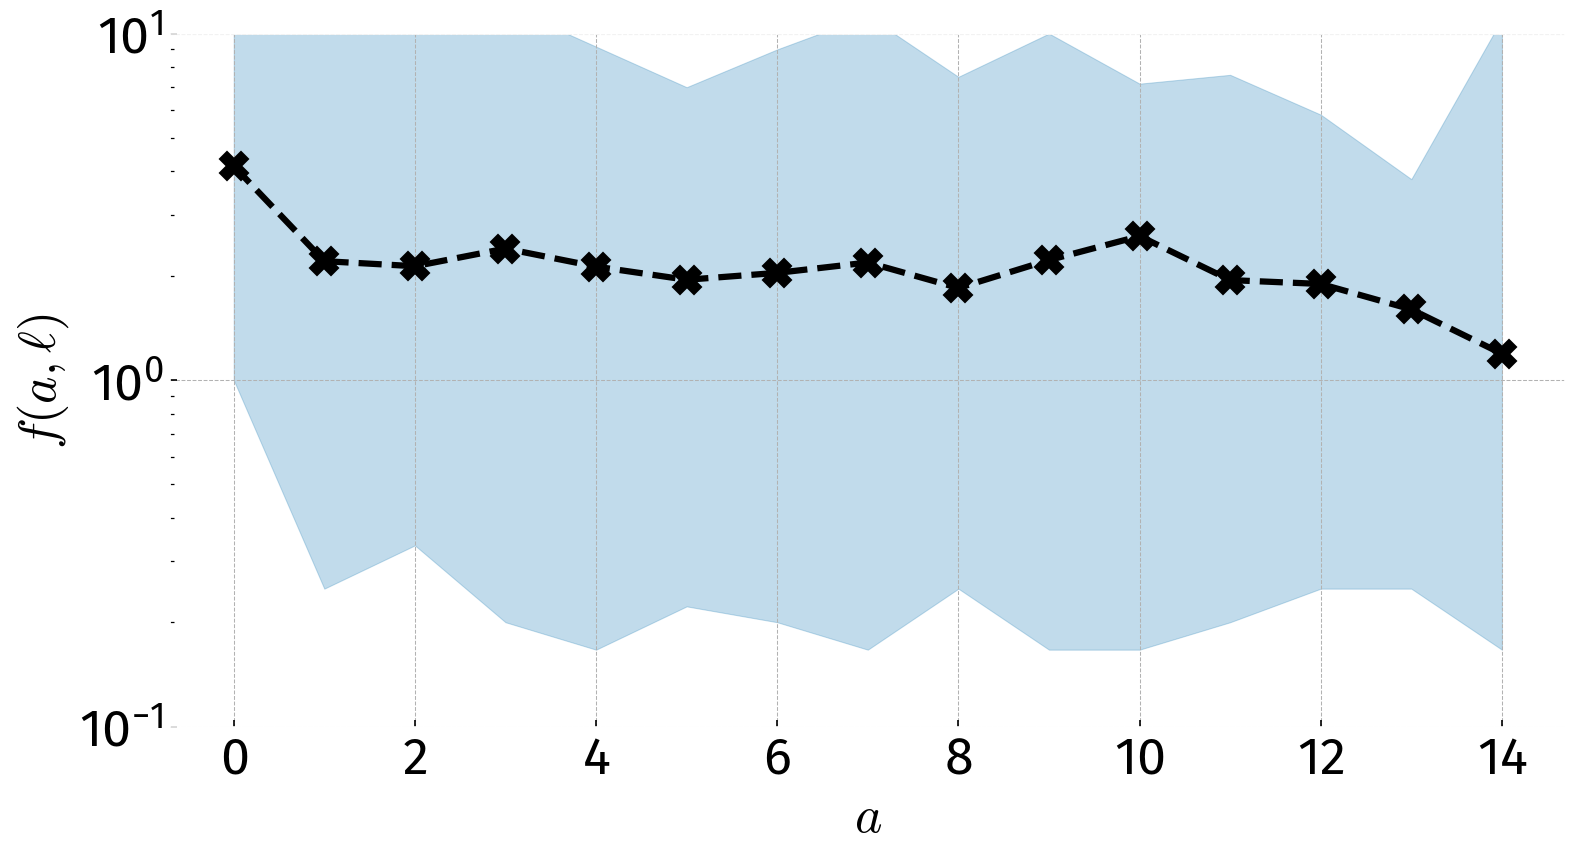

In [45]:
plt.figure(figsize=(12,6))
plt.xlabel("$a$")
plt.ylabel(r"$f(a, \ell)$")
plt.semilogy()
plt.ylim(10**(-1), 10)
plt.plot(fig1['mit'][2]['f'].index, fig1['mit'][2]['f']['f'], marker="X", markersize=13, ls="dashed", lw=3, color="black")
plt.fill_between(testing.index, testing['low'], testing['high'], color=colors[0], alpha=0.3)

In [58]:
np.random.seed(0)
t0 = dt.datetime.now()
fig1cib = {}
for c in fig1.keys():
    fig1cib[c] = {}
    ssize = []
    for i in range(3):
        nsample = len(fig1[c][i]['fi'].keys())
        allsamples = pd.DataFrame()
        en = 0
        for _ in range(100):
            egosample = np.random.choice(list(fig1[c][i]['fi'].keys()), size=nsample, replace=True)
            for ego in egosample:
                df = fig1[c][i]['fi'][ego].rename({'f': en}, axis='columns').transpose()
                allsamples = pd.concat([allsamples, df])
                en += 1
        ssize.append(len(allsamples))
        fig1cib[c][i] = allsamples.quantile([0.025, 0.975]).transpose().rename({0.025: 'low', 0.975: 'high'}, axis='columns').sort_index()
    tf = dt.datetime.now()
    print(f'Finished {c} in {tf - t0} with sample size {ssize}')
    t0 = dt.datetime.now()

Finished uk2 in 0:00:08.337866 with sample size [2900, 2900, 2400]
Finished itb in 0:00:35.213076 with sample size [14000, 10800, 6200]
Finished it in 0:00:40.428186 with sample size [14200, 12000, 9200]
Finished mit in 0:00:32.744224 with sample size [12400, 11200, 9700]


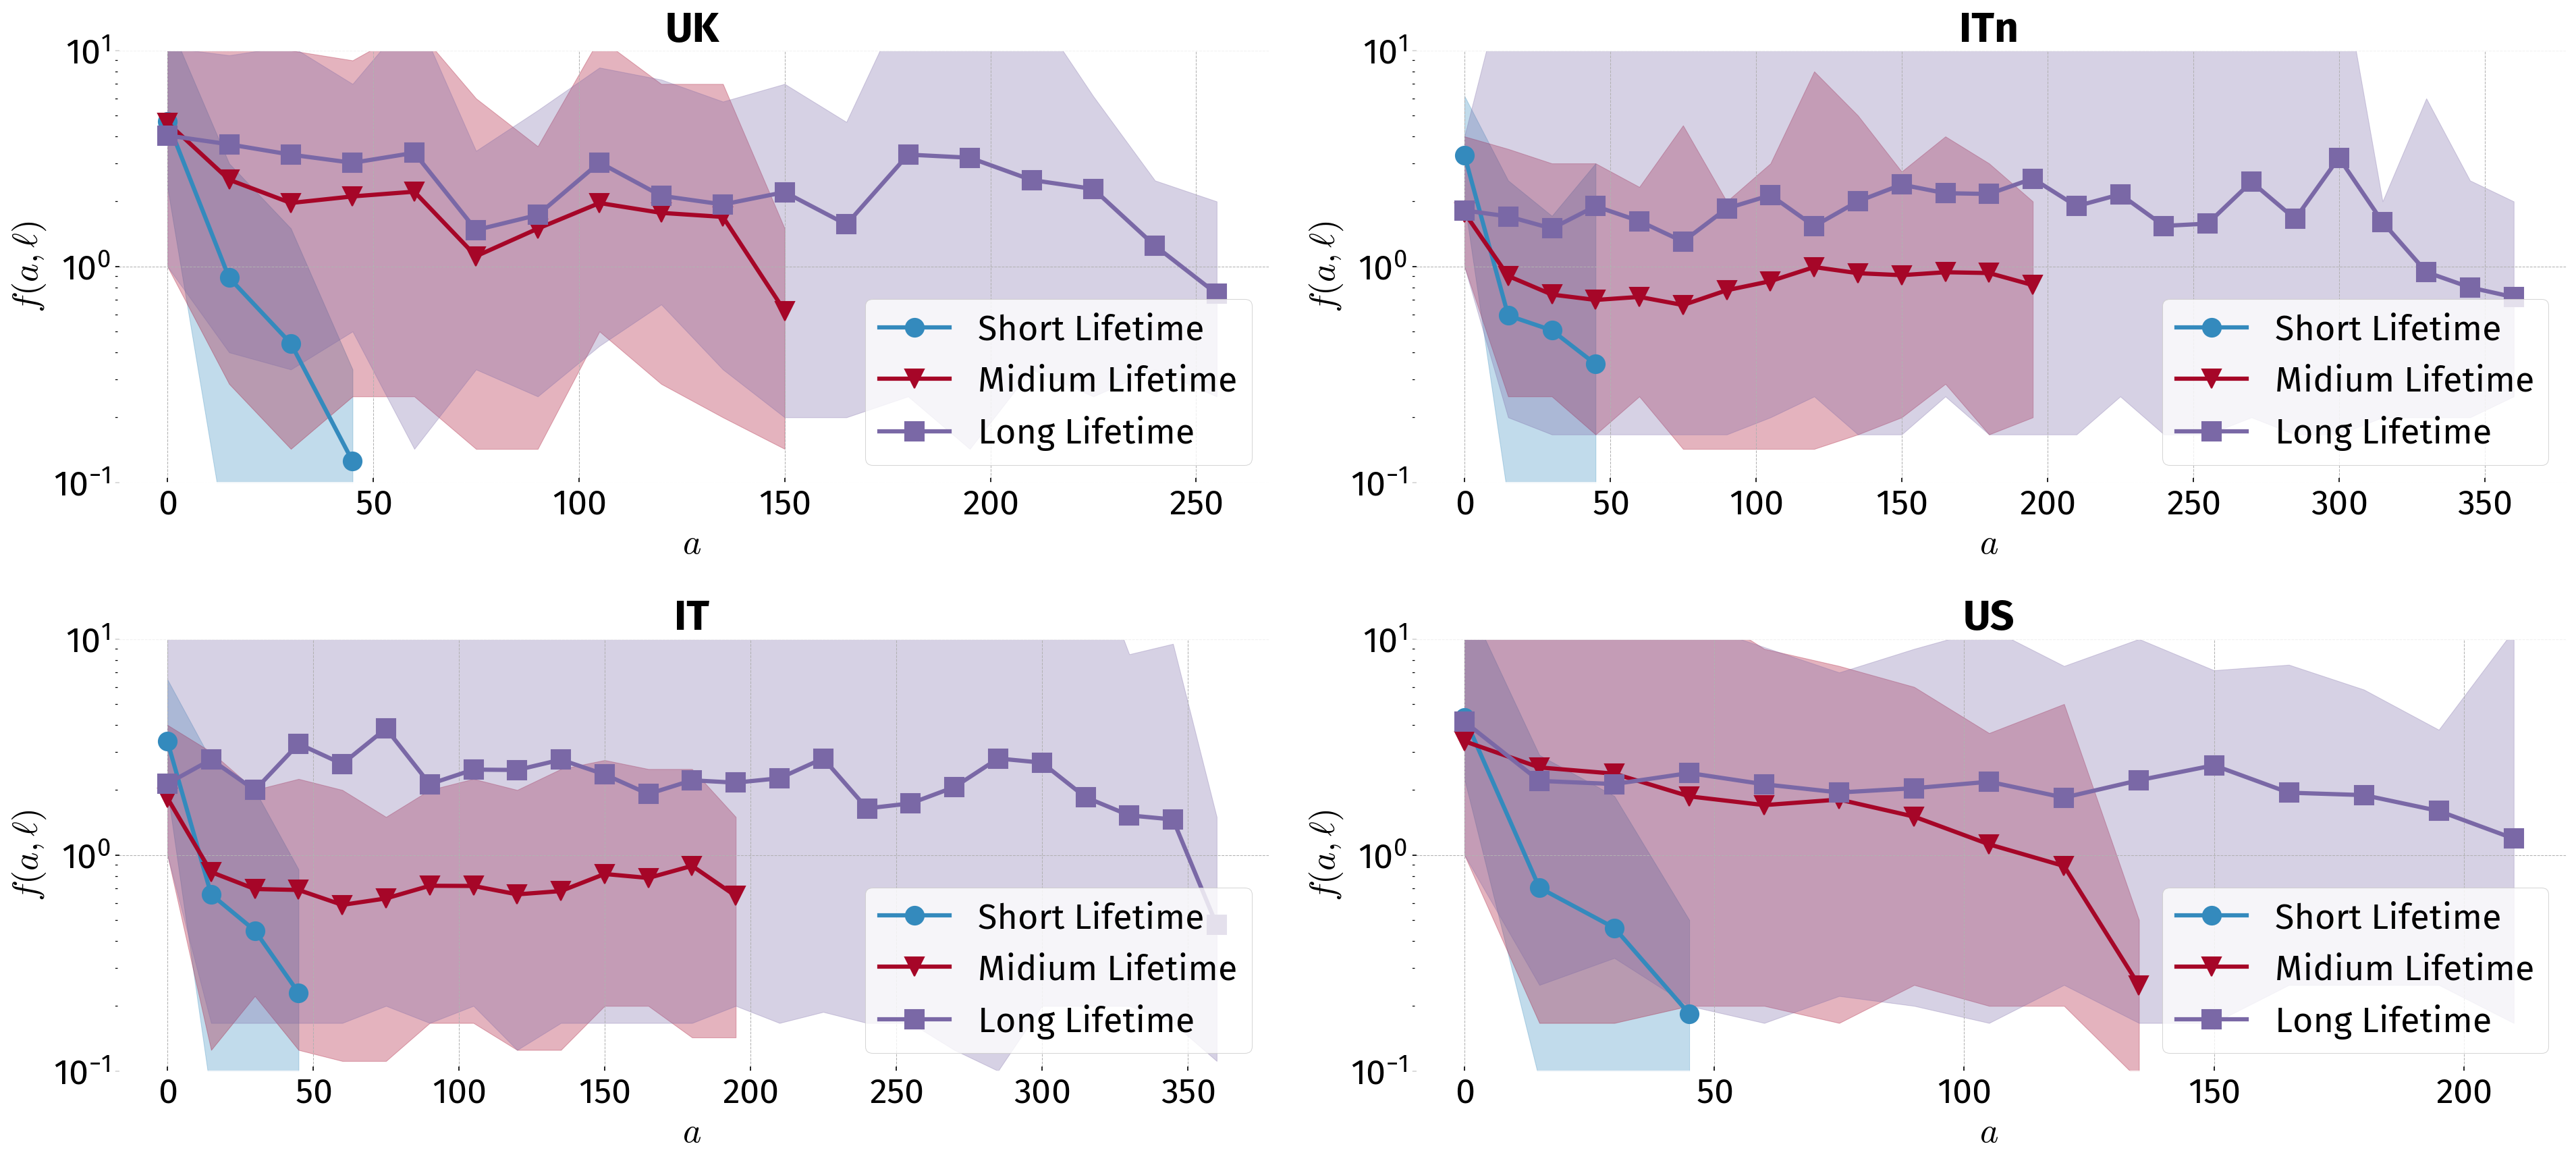

In [59]:
nc = 2
nr = 2
plt.figure(figsize=(nc*13, nr*6))
p = 1
for c in fig1.keys():
    plt.subplot(nr, nc, p)
    plt.title(f'{country_labels[c]}')
    plt.xlabel("$a$")
    plt.ylabel(r"$f(a, \ell)$")
    plt.semilogy()
    plt.ylim(10**(-1), 10)
    for i in range(3):
        plt.plot(fig1[c][i]['f'].index * 15, fig1[c][i]['f']['f'], marker=markers[i], markersize=13, ls="solid", lw=3, color=colors[i], label=['Short Lifetime', 'Midium Lifetime', 'Long Lifetime'][i])
        plt.fill_between(fig1cib[c][i].index * 15, fig1cib[c][i]['low'], fig1cib[c][i]['high'], color=colors[i], alpha=0.3)
    plt.legend()
    plt.tight_layout()
    p += 1

In [60]:
np.random.seed(0)
t0 = dt.datetime.now()
fig1cib = {}
for c in fig1.keys():
    fig1cib[c] = {}
    ssize = []
    for i in range(3):
        nsample = len(fig1[c][i]['fi'].keys())
        allsamples = pd.DataFrame()
        en = 0
        for _ in range(500):
            egosample = np.random.choice(list(fig1[c][i]['fi'].keys()), size=nsample, replace=True)
            for ego in egosample:
                df = fig1[c][i]['fi'][ego].rename({'f': en}, axis='columns').transpose()
                allsamples = pd.concat([allsamples, df])
                en += 1
        ssize.append(len(allsamples))
        fig1cib[c][i] = allsamples.quantile([0.025, 0.975]).transpose().rename({0.025: 'low', 0.975: 'high'}, axis='columns').sort_index()
    tf = dt.datetime.now()
    print(f'Finished {c} in {tf - t0} with sample size {ssize}')
    t0 = dt.datetime.now()

Finished uk2 in 0:00:43.562443 with sample size [14500, 14500, 12000]
Finished itb in 0:04:08.827551 with sample size [70000, 54000, 31000]
Finished it in 0:04:00.039253 with sample size [71000, 60000, 46000]
Finished mit in 0:03:02.657706 with sample size [62000, 56000, 48500]


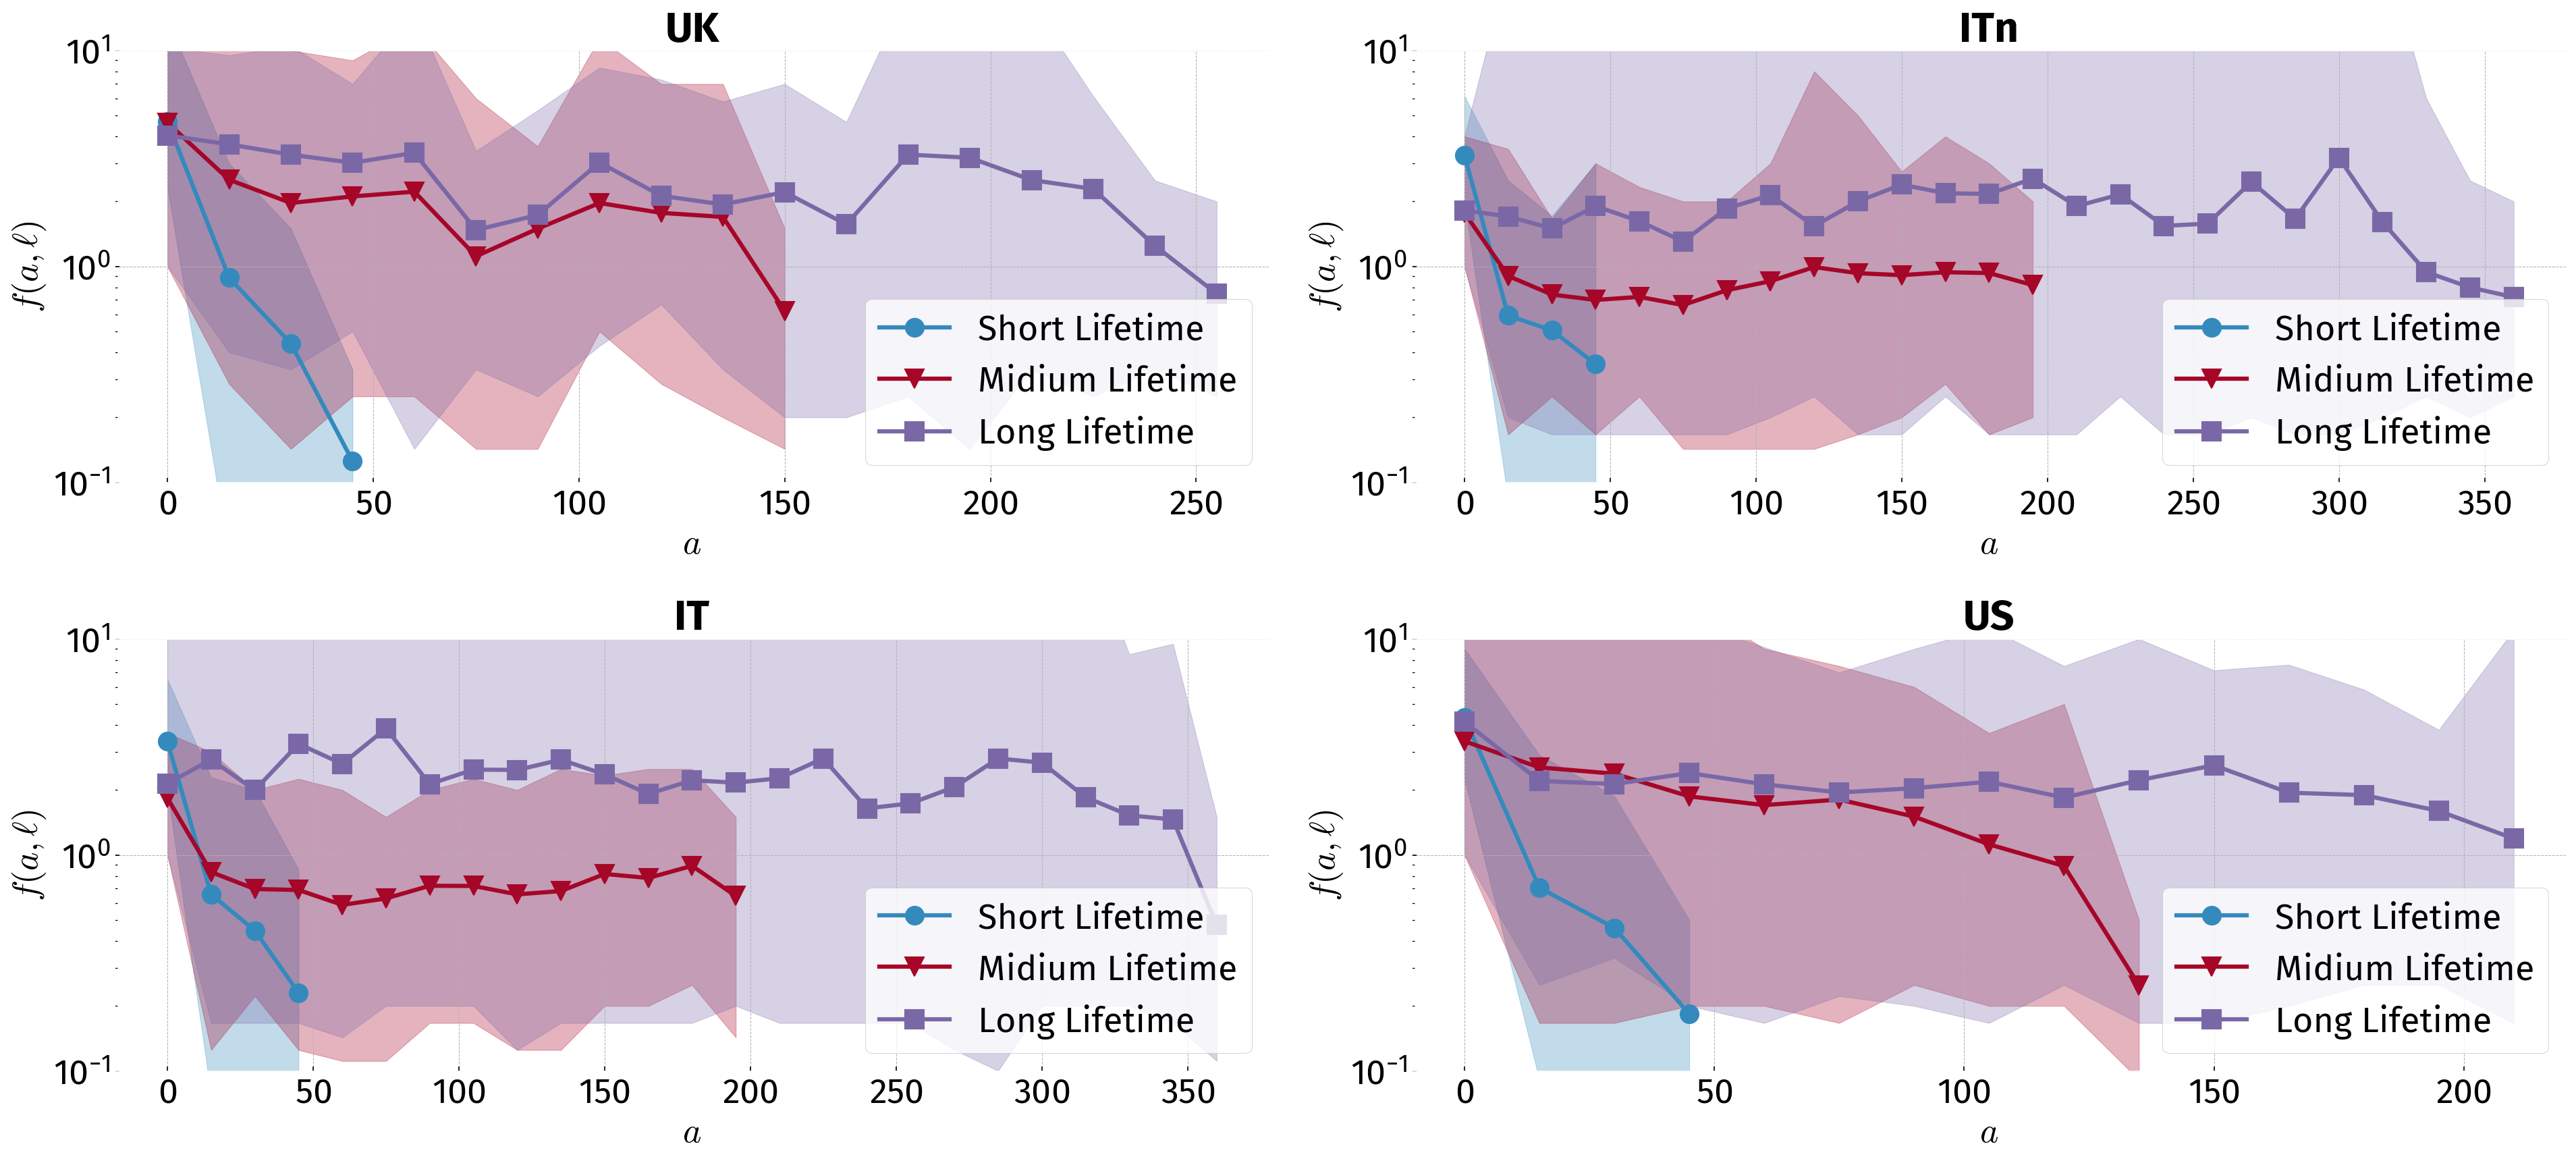

In [61]:
nc = 2
nr = 2
plt.figure(figsize=(nc*13, nr*6))
p = 1
for c in fig1.keys():
    plt.subplot(nr, nc, p)
    plt.title(f'{country_labels[c]}')
    plt.xlabel("$a$")
    plt.ylabel(r"$f(a, \ell)$")
    plt.semilogy()
    plt.ylim(10**(-1), 10)
    for i in range(3):
        plt.plot(fig1[c][i]['f'].index * 15, fig1[c][i]['f']['f'], marker=markers[i], markersize=13, ls="solid", lw=3, color=colors[i], label=['Short Lifetime', 'Midium Lifetime', 'Long Lifetime'][i])
        plt.fill_between(fig1cib[c][i].index * 15, fig1cib[c][i]['low'], fig1cib[c][i]['high'], color=colors[i], alpha=0.3)
    plt.legend()
    plt.tight_layout()
    p += 1